In [22]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import os
!pip install contractions
import contractions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Attention

In [23]:
!pip install tensorflow

In [24]:
!pip install textblob

In [25]:
# Load dataset
df = pd.read_csv('ENG_SA_Dataset.csv')  

# Data Preprocessing
#Contraction expansion
def cont_exp(text):
    text = text.lower()
    text = contractions.fix(text)
    return text

#Remove email
def remove_emails(text):
    regex = r"\S*@\S*\s?"
    text = re.sub(regex, "", text)
    return text

#Remove HTML tags
def remove_html_tags(text):
    regex = r"<.*?>"
    text = re.sub(regex, "", text)
    return text

#Remove URL
def remove_urls(text):
    regex = r'http\S+|www\S+|https\S+'
    text = re.sub(regex, '', text)
    return text

#Remove Special Characters
def remove_special_characters(text):
    regex = r'[^a-zA-Z0-9\s]'
    text = re.sub(regex, '', text)
    return text

#Remove Accented Characters
import unicodedata
def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#Text normalization
def make_base(text):
    return re.sub(r'\s+', ' ', text.strip().lower())



#Spelling Correction
from textblob import TextBlob
def spelling_correction(text):
    return str(TextBlob(text).correct())


In [26]:
df["cleaned_text"] = df["text"].apply(cont_exp)
df["cleaned_text"] = df["cleaned_text"].apply(remove_emails)
df["cleaned_text"] = df["cleaned_text"].apply(remove_html_tags)
df["cleaned_text"] = df["cleaned_text"].apply(remove_urls)
df["cleaned_text"] = df["cleaned_text"].apply(remove_special_characters)
df["cleaned_text"] = df["cleaned_text"].apply(remove_accented_characters)
df["cleaned_text"] = df["cleaned_text"].apply(make_base)
#df["cleaned_text"] = df["text"].apply(spelling_correction) #take a long time

In [27]:
df.head(30)

,id,text,label,sentiment,cleaned_text
0,9536,"Cooking microwave pizzas, yummy",2,positive,cooking microwave pizzas yummy
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral,any plans of allowing sub tasks to show up in ...
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive,i love the humor i just reworded it like sayin...
3,14182,naw idk what ur talkin about,1,neutral,naw i do not know what you are talkin about
4,17840,That sucks to hear. I hate days like that,0,negative,that sucks to hear i hate days like that
5,3655,Umm yeah. That`s probably a pretty good note ...,2,positive,umm yeah thats probably a pretty good note to ...
6,719,whatever do you mean?,1,neutral,whatever do you mean
7,22823,That would panic me a little! Maybe you can ...,0,negative,that would panic me a little maybe you can rea...
8,4869,Is sad when people`s phones are dead,0,negative,is sad when peoples phones are dead
9,793,sad face.,0,negative,sad face


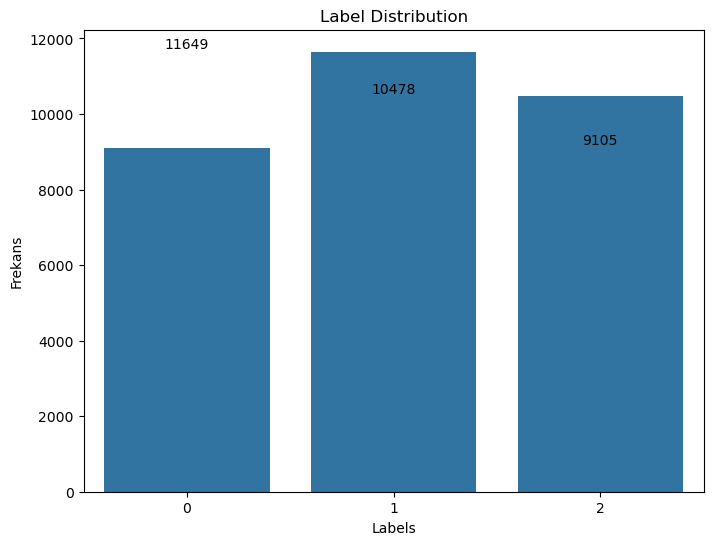

In [28]:
#Compose count plot to analyze labels counts
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frekans')


for i, count in enumerate(label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

Labels are balanced so I did not smooting

In [29]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index

In [30]:
# Padding
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

In [32]:
#MODEL IMPLEMNETATION
#Glove Embedding integration
embedding_dim = 100
embedding_index = {}
with open(os.path.join('glove.6B.100d.txt'), 'r', encoding='utf-8') as file:
    for line in file:
        values = line.strip().split()  # Strip whitespaces
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except ValueError:
            # Handle lines with potential formatting issues
            print(f"Skipping line due to ValueError: {line}")
            continue
        embedding_index[word] = coefs

In [33]:
# Create embedding matrix
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Check vector dimension
        if embedding_vector.shape == (embedding_dim,):
            embedding_matrix[i] = embedding_vector
        else:
            # Padding with zeros to match embedding_dim
            print(f"Padding word '{word}' with zeros due to embedding dimension mismatch: {embedding_vector.shape}")
            embedding_matrix[i] = np.pad(embedding_vector, (0, embedding_dim - embedding_vector.shape[0]), 'constant')

In [34]:
#NEURAL NETWORK ARCHİTECTURE


# Create Model 
def build_model():
    # Input Layer
    inputs = Input(shape=(max_sequence_length,))

    # Embedding Layer
    embedding_layer = Embedding(input_dim=vocab_size,
                                 output_dim=embedding_dim,
                                 weights=[embedding_matrix],
                                 input_length=max_sequence_length,
                                 trainable=True)(inputs)

    # LSTM Layer
    lstm_output = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

    # Attention Layer
    attention_layer = Attention()([lstm_output, lstm_output])

    # Dropout + BatchNorm
    dropout_layer = Dropout(0.3)(attention_layer)
    batch_norm_layer = BatchNormalization()(dropout_layer)

    # GRU Layer
    gru_layer = Bidirectional(GRU(96))(batch_norm_layer)

    # Dense Layer
    dense_layer = Dense(256, activation='relu', kernel_regularizer='l2')(gru_layer)
    dense_dropout_layer = Dropout(0.4)(dense_layer)

    # Output Layer
    output_layer = Dense(3, activation='softmax')(dense_dropout_layer)

    # Model Definition
    model = Model(inputs=inputs, outputs=output_layer)

    # Compile
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# create model
model = build_model()

# Early stopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# train model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[stop_early])

# validation
y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Epoch 1/10


C:\Users\sezgi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - accuracy: 0.5070 - loss: 2.1146 - val_accuracy: 0.5009 - val_loss: 1.0995
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.6828 - loss: 0.7961 - val_accuracy: 0.7002 - val_loss: 0.7269
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.7320 - loss: 0.6604 - val_accuracy: 0.6982 - val_loss: 0.7418
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.7739 - loss: 0.5746 - val_accuracy: 0.6934 - val_loss: 0.7559
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.8244 - loss: 0.4800 - val_accuracy: 0.6546 - val_loss: 0.8960
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1824
           1       0.60      0.55      0.57      2322
           2       0.66      0.78      0.72      2101

    accuracy                           0.65      6247
   macro avg       0.65      0.65      0.65   

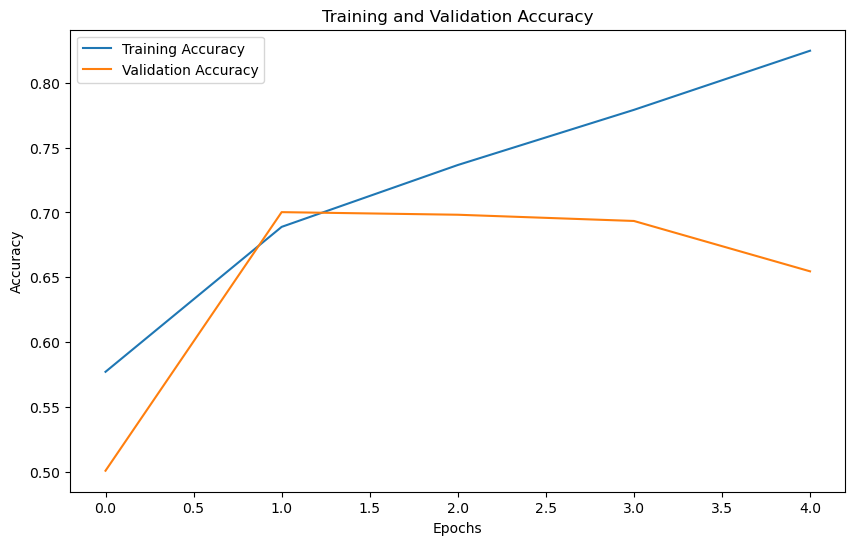

In [35]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


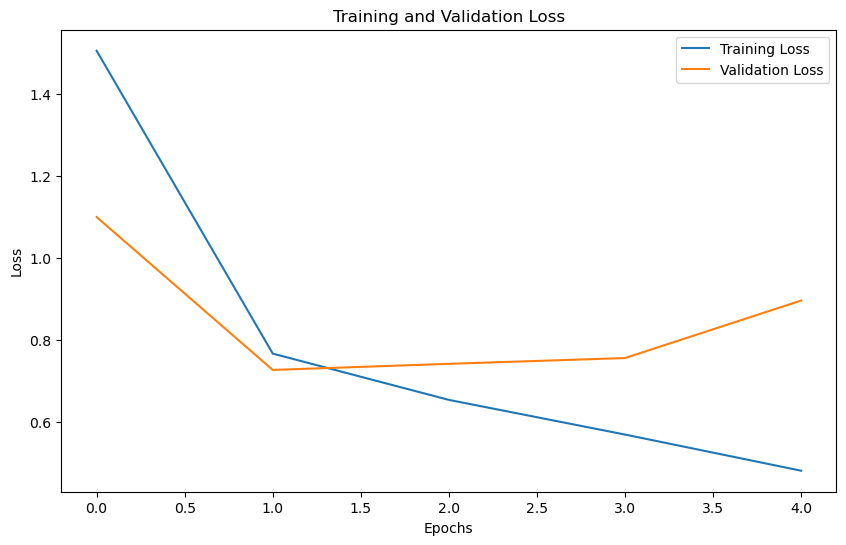

In [36]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
